In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
from PIL import Image 

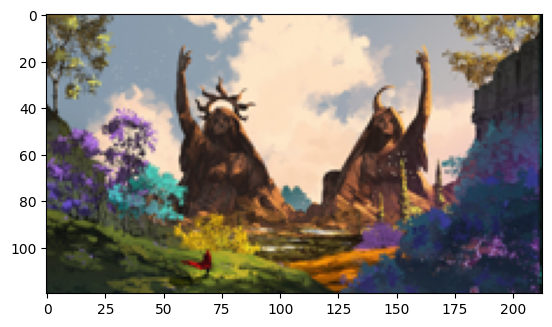

In [2]:
image_path = 'C:\\Users\\bkand\\OneDrive\\Pictures\\Camera imports\\2024-09-29\\1.jpg'

with Image.open(image_path) as im: 
    w, h = im.size; ratio = w/h
    im = im.resize((int(ratio*120), 120))
    img = np.asarray(im)
plt.imshow(img)

In [ ]:
# Bayers dithering levels
M2 = (1/4) * np.array([
    0, 2, 
    3, 1
]).reshape(2, 2)

M4 = (1/16) * np.array([
    0, 8, 2, 10, 
    12, 4, 14, 6, 
    3, 11, 1, 9, 
    15, 7, 13, 5
]).reshape(4, 4)

M8 = (1/64) * np.array([
    0, 32, 8, 40, 2, 32, 10, 42, 
    48, 16, 56, 24, 50, 18, 58, 26, 
    12, 44, 4, 26, 14, 46, 6, 38, 
    60, 28, 52, 20, 62, 30, 54, 22, 
    3, 35, 11, 43, 1, 33, 9, 41, 
    51, 19, 59, 27, 49, 17, 57, 25, 
    15, 47, 7, 39, 13, 45, 5, 37, 
    63, 31, 55, 23, 61, 29, 53, 21
]).reshape(8, 8)

color_palette = np.array([ 
    [0 ,0 ,0], # black 
    [255, 0, 0], # red
    [0, 255, 0], # green
    [255, 255, 0], # yellow
    [0, 0, 255], # blue
    [255, 0, 255], # magenta
    [255, 255, 255], # white
    [150, 75, 0], # brown
    [0, 127, 127], # cyan50

    [127, 0, 0], # red50
    [0, 127, 0], # green50
    [127, 127, 0], # yellow50
    [0, 0, 127], # blue50
    [127, 0, 127], # magenta50
    [192, 192, 192] # gray75
])

color_palette_names = [ 
    'Black', 'Red', 'Green', 'Yellow', 'Blue', 'Magenta', 'White', 'Brown', 'Cyan50', 'Red50', 'Green50', 'Yellow50', 'Blue50', 'Magenta50', 'Gray75'
]

def nearest_color_palette(c): 
    # quantizing to 16 colors
    c_hat = np.clip((255 * c), 0, 255).astype('uint8')
    err = ((color_palette - c_hat)**2).sum(axis=1)
    idx = np.argmin(err) # the index of minimum error
    return color_palette_names[idx], color_palette[idx]

n = 8 # color num
w, h = img.shape[:2]
r = 1 # 255/n  # spread 

new_img = np.zeros(img.shape)
new_img_img = ''
for x in range(w):
    for y in range(h):
        pixel_name, pixel = nearest_color_palette( (1/255)*img[x, y] + r * M8[x%8, y%8] -.5)
        new_img[x, y] = pixel
        new_img_img += f'Dot {pixel_name}, {x}, {y}\n'

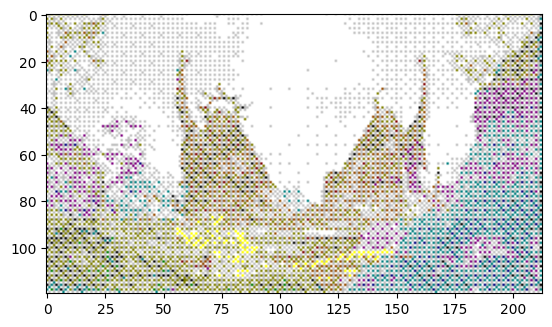

In [22]:
plt.imshow(new_img.astype('uint8'))

In [12]:
# convert to Video Generator Format (file called face.img)

with open('face.img', '+a') as face_img: 
    face_img.write(new_img_img)